<a href="https://colab.research.google.com/github/dhanalakshmi3149/diabatics/blob/main/grocery_dataset_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark


In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
.master("local")\
.appName("ClusteringApp")\
.enableHiveSupport()\
.config('spark.ui.port', '4050')\
.getOrCreate()

In [20]:
path="/content/drive/MyDrive/Colab Notebooks/Grocery.csv"


In [21]:
#Reading  csv file
df = spark.read.csv(path,
                             inferSchema=True,
                             header=True)

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
df.show(7)
df.count()

+-------+------+-----+----+-------+------+----------------+----------+
|Channel|Region|Fresh|Milk|Grocery|Frozen|Detergents_Paper|Delicassen|
+-------+------+-----+----+-------+------+----------------+----------+
|      2|     3|12669|9656|   7561|   214|            2674|      1338|
|      2|     3| 7057|9810|   9568|  1762|            3293|      1776|
|      2|     3| 6353|8808|   7684|  2405|            3516|      7844|
|      1|     3|13265|1196|   4221|  6404|             507|      1788|
|      2|     3|22615|5410|   7198|  3915|            1777|      5185|
|      2|     3| 9413|8259|   5126|   666|            1795|      1451|
|      2|     3|12126|3199|   6975|   480|            3140|       545|
+-------+------+-----+----+-------+------+----------------+----------+
only showing top 7 rows



440

In [26]:
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+-------+------+-----+----+-------+------+----------------+----------+
|Channel|Region|Fresh|Milk|Grocery|Frozen|Detergents_Paper|Delicassen|
+-------+------+-----+----+-------+------+----------------+----------+
|      0|     0|    0|   0|      0|     0|               0|         0|
+-------+------+-----+----+-------+------+----------------+----------+



In [27]:
data_df=df.toPandas()


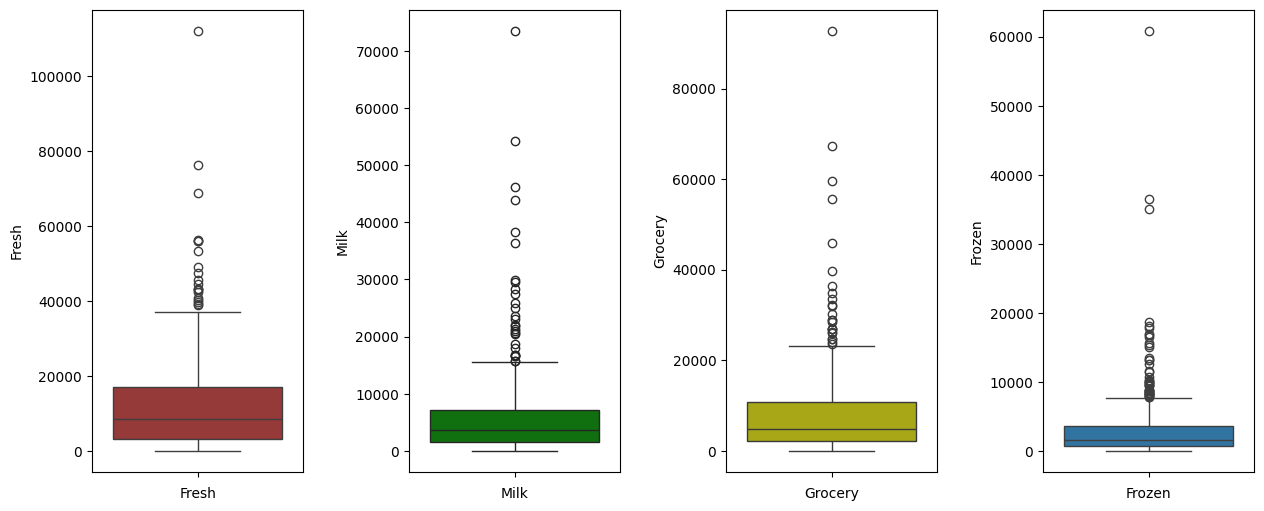

In [30]:
# initialize figure with 4 subplots in a row
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn
fig, ax = plt.subplots(1, 4, figsize=(15, 6))

# add padding between the subplots
plt.subplots_adjust(wspace=0.5)

# draw boxplot for age in the 1st subplot
sns.boxplot(data=data_df['Fresh'], ax=ax[0], color='brown',)
ax[0].set_xlabel('Fresh')

# draw boxplot for station_distance in the 2nd subplot
sns.boxplot(data=data_df['Milk'], ax=ax[1], color='g')
ax[1].set_xlabel('Milk')

# draw boxplot for stores_count in the 3rd subplot
sns.boxplot(data=data_df['Grocery'], ax=ax[2], color='y')
ax[2].set_xlabel('Grocery')

# finally draw boxplot for unit_price in the 4th subplot
sns.boxplot(data=data_df['Frozen'], ax=ax[3])
ax[3].set_xlabel('Frozen')

# by default, you'll see x-tick label set to 0 in each subplot
# remove it by setting it to empty list
for subplot in ax:
    subplot.set_xticklabels([])

plt.show()

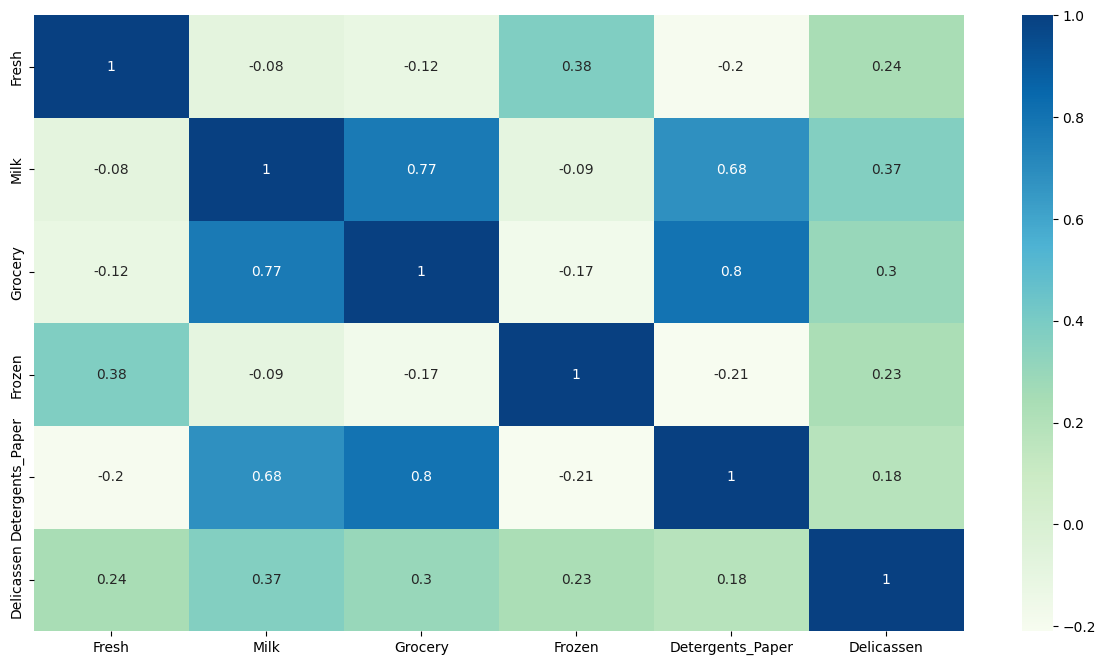

In [31]:
numerical_features = ['Fresh', 'Milk', 'Grocery',
       'Frozen', 'Detergents_Paper', 'Delicassen'
       ]

plt.figure(figsize=(15, 8))
sns.heatmap(round(data_df[numerical_features].corr(method='spearman'), 2),
            annot=True, mask=None, cmap='GnBu')
plt.show()

In [32]:
from pyspark.ml.feature import VectorAssembler
ClusteringColumns = ['Fresh', 'Milk', 'Grocery']

assembler=VectorAssembler(inputCols=ClusteringColumns, outputCol="features")
featureDf = assembler.transform(df)
featureDf.printSchema()
featureDf.show(10)

root
 |-- Channel: integer (nullable = true)
 |-- Region: integer (nullable = true)
 |-- Fresh: integer (nullable = true)
 |-- Milk: integer (nullable = true)
 |-- Grocery: integer (nullable = true)
 |-- Frozen: integer (nullable = true)
 |-- Detergents_Paper: integer (nullable = true)
 |-- Delicassen: integer (nullable = true)
 |-- features: vector (nullable = true)

+-------+------+-----+-----+-------+------+----------------+----------+--------------------+
|Channel|Region|Fresh| Milk|Grocery|Frozen|Detergents_Paper|Delicassen|            features|
+-------+------+-----+-----+-------+------+----------------+----------+--------------------+
|      2|     3|12669| 9656|   7561|   214|            2674|      1338|[12669.0,9656.0,7...|
|      2|     3| 7057| 9810|   9568|  1762|            3293|      1776|[7057.0,9810.0,95...|
|      2|     3| 6353| 8808|   7684|  2405|            3516|      7844|[6353.0,8808.0,76...|
|      1|     3|13265| 1196|   4221|  6404|             507|      1788|

In [33]:
#preparing data for clustering
featureDf.count()
trainingData, testData = featureDf.randomSplit([0.7, 0.3], seed = 5043)
print(type(trainingData))
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))
trainingData.show(10)
testData.columns

<class 'pyspark.sql.dataframe.DataFrame'>
Training Dataset Count: 316
Test Dataset Count: 124
+-------+------+-----+-----+-------+------+----------------+----------+--------------------+
|Channel|Region|Fresh| Milk|Grocery|Frozen|Detergents_Paper|Delicassen|            features|
+-------+------+-----+-----+-------+------+----------------+----------+--------------------+
|      1|     1|  514| 8323|   6869|   529|              93|      1040|[514.0,8323.0,686...|
|      1|     1|  583|  685|   2216|   469|             954|        18|[583.0,685.0,2216.0]|
|      1|     1|  964| 4984|   3316|   937|             409|         7|[964.0,4984.0,331...|
|      1|     1| 1537| 3748|   5838|  1859|            3381|       806|[1537.0,3748.0,58...|
|      1|     1| 1869|  577|    572|   950|            4762|       203|[1869.0,577.0,572.0]|
|      1|     1| 1956|  891|   5226|  1383|               5|      1328|[1956.0,891.0,522...|
|      1|     1| 2083| 5007|   1563|  1120|             147|      155

['Channel',
 'Region',
 'Fresh',
 'Milk',
 'Grocery',
 'Frozen',
 'Detergents_Paper',
 'Delicassen',
 'features']

In [34]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
cluster_count = [5]#[10,30,50,70,90]
wssse_values =[]
for i in range(2,8):
  kmeans = KMeans().setK(i).setSeed(1).setFeaturesCol("features").setPredictionCol("prediction")
  kmeansModel = kmeans.fit(trainingData)

  # test the model with test data set
  predictDf = kmeansModel.transform(testData)


  evaluator = ClusteringEvaluator()
  silhouette = evaluator.evaluate(predictDf)

  wssse_values.append(silhouette)
  print("clusters= "+str(i) +" Silhouette with squared euclidean distance: "+ str(silhouette))
  #for clusters in kmeansModel.clusterCenters():
    #print("cluster centres",clusters

clusters= 2 Silhouette with squared euclidean distance: 0.6458135149211761
clusters= 3 Silhouette with squared euclidean distance: 0.6580959577405316
clusters= 4 Silhouette with squared euclidean distance: 0.5854556894072328
clusters= 5 Silhouette with squared euclidean distance: 0.5523590775631999
clusters= 6 Silhouette with squared euclidean distance: 0.5313625049075387
clusters= 7 Silhouette with squared euclidean distance: 0.43224285468732243


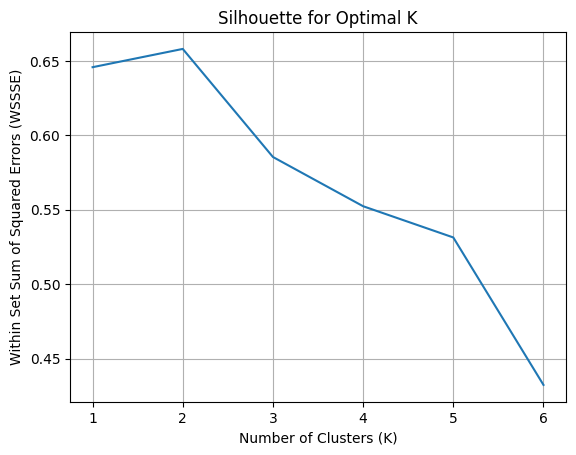

In [35]:
# Plotting WSSSE values
plt.plot(range(1, 7), wssse_values)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)')
plt.title('Silhouette for Optimal K')
plt.grid()
plt.show()

In [36]:
# test the model with test data set
predictDf = kmeansModel.transform(testData)
predictDf.show(10)
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictDf)
print("Silhouette with squared euclidean distance = " + str(silhouette))

+-------+------+-----+-----+-------+------+----------------+----------+--------------------+----------+
|Channel|Region|Fresh| Milk|Grocery|Frozen|Detergents_Paper|Delicassen|            features|prediction|
+-------+------+-----+-----+-------+------+----------------+----------+--------------------+----------+
|      1|     1| 1838| 6380|   2824|  1218|            1216|       295|[1838.0,6380.0,28...|         1|
|      1|     1| 2806|10765|  15538|  1374|            5828|      2388|[2806.0,10765.0,1...|         2|
|      1|     1| 4155|  367|   1390|  2306|              86|       130|[4155.0,367.0,139...|         1|
|      1|     1| 5041| 1115|   2856|  7496|             256|       375|[5041.0,1115.0,28...|         1|
|      1|     1| 5396| 7503|  10646|    91|            4167|       239|[5396.0,7503.0,10...|         2|
|      1|     1| 5909|23527|  13699| 10155|             830|      3636|[5909.0,23527.0,1...|         2|
|      1|     1| 6373|  780|    950|   878|             288|    

In [37]:
predictDf.groupBy("prediction").count().show()


+----------+-----+
|prediction|count|
+----------+-----+
|         1|   52|
|         6|    2|
|         5|    4|
|         2|   28|
|         0|   38|
+----------+-----+



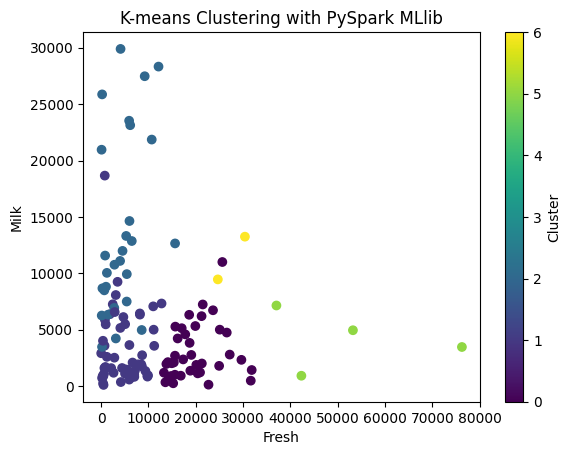

In [38]:
# Converting to Pandas DataFrame
clustered_data_pd = predictDf.toPandas()
# Visualizing the results
plt.scatter(clustered_data_pd["Fresh"], clustered_data_pd["Milk"], c=clustered_data_pd["prediction"], cmap='viridis')
plt.xlabel("Fresh")
plt.ylabel("Milk")
plt.title("K-means Clustering with PySpark MLlib")
plt.colorbar().set_label("Cluster")
plt.show()

In [39]:
import plotly.express as px


In [40]:
fig = px.scatter_3d(clustered_data_pd, x='Fresh', y='Milk', z='Grocery', color='prediction')
fig.show()